## Replicación de cálculo de Fracción de Anisotropía en Imágenes de Resonancia Magnética obtenidas por Difusión.

### Samuel Romero Santiago
### Diciembre 2022
**Introducción**

Las imágenes por tensor de difusión (DTI) son un método de imagenología por resonancia magnética (IRM) que permite cuantificar el grado de difusión (entre otras propiedades) de los protones de agua en los tejidos en particular la sustancia blanca del cerebro. En particular, las DTI se pueden utilizar para mapear y caracterizar la difusión tridimensional del agua en función de la ubicación espacial. Su importancia se deriva en que es una técnica no invasiva, por lo que es muy usada para monitoriar cambios en el tejido, analizar lesiones, planear tratamientos, etc. 
De estas DTI's se pueden derivar varias métricas cuantitativas en las que destaca la fracción de anisotropía (FA), que en pocas palabras es la "cantidad de movimiento o difusión" en cierto punto tridimensional de estas DTI. Esta métrica tiene muchas aplicaciones además de parecer bastante sensible a un amplio aspectro de condiciones patológicas.
Usualmente los softwares utilizados para en análisis de DTI realizan el cálculo de las métricas de manera automática por lo que es poco intuitivo entender los calculos y algortimos que se requieren. Es por eso que en el presente proyecto se realizará el cálculo del FA para una imagen DTI y se comparará con el mapa de FA obtenido en el software especializado.

**Nota sobre Imagen usada**

Se utilizó una imagen DTI obtenida en el Laboratorio Nacional de Imagenología por Resonancia Magnética del Instituto de Neurobiología de la Universidad Nacional Autónoma de México. La imagen es de cerebro de un ratón de la cepa c-57 de 28 días de nacido. 
A continuación se muestra una "rebanada" de como se ve una imagen DTI sin calcular el FA.


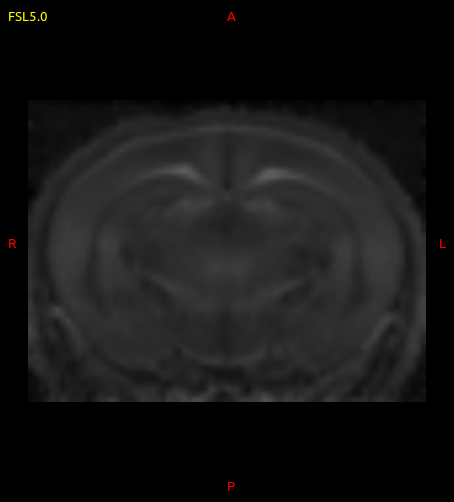


**Factor de Anisotropía a partir de DTI**

Las imágenes DTI están representadas en arreglos de 4 dimensiones, las primeras tres corresponden a la posición espacial del voxel (pixel tridimensional) por lo que pueden ser de tamaño n (dependiendo de como fue obtenida la imagen), por su parte la 4 dimesión del tensor, corresponde a información de difusión para cada voxel, se trata de un arreglo de tamaño 6 que representa a una matriz 3x3 de covarianzas tal que:

$$D=
\begin{pmatrix}
    D_{xx} & D_{xy} & D_{xz}\\
    D_{yx} & D_{yy} & D_{yz}\\
    D_{zx} & D_{zy} & D_{zz}\\
\end{pmatrix}
$$

Esta matriz describe las covarianzas de los desplazamientos de difusión en tres dimensiones normalizados por el tiempo de difusión. Los elementos diagonales ($D_{ii}$ > 0) son las varianza de la difusión en los ejes X Y y Z, and the off-diagonal elements are the covariance terms and are symmetric about the diagonal ($D_{ij}=D_{ji}$), así el arreglo de tamaño seis antes mencionado representa esta matriz de la siguiente forma: $D$=($D_{xx}$,$D_{yy}$,$D_{zz}$,$D_{xy}=D_{yx}$,$D_{xz}=D_{zx}$,$D_{yz}=D_{zy}$).

La diagonalización del tensor de difusión produce los valores propios $(\lambda_1,\lambda_2,\lambda_3)$ y los vectores propios correspondientes del tensor de difusión, que describen las direcciones y las difusividades a lo largo de los ejes de difusión principal. El tensor de difusión se puede visualizar como una elipsoide, con los vectores propios que definen las direcciones de los ejes principales y los radios elipsoidales definidos por los valores propios. La difusión se considera isotrópica cuando
los valores propios son casi iguales $(\lambda_1\approx\lambda_2\approx\lambda_3)$ . Por el contrario, el tensor de difusión es anisotrópico cuando los valores propios son significativamente diferentes en magnitud  $(\lambda_1>\lambda_2>\lambda_3)$.

El calculo de FA entonces se hace de la siguiente forma:

<center>$FA=\sqrt{\frac{3((\lambda_1-MD)^2+(\lambda_2-MD)^2+(\lambda_3-MD)^2)}{2(\lambda_1^2+\lambda_2^2+\lambda_3^2)}}$</center>
    
Donde $\lambda_1,\lambda_2,\lambda_3$ corresponden a los eigenvalores de D y MD, corresponde al promedio de estos eigenvalores, es decir:
    
<center>$MD=\frac{\lambda_1,\lambda_2,\lambda_3}{3}$</center>



Así, el FA$\in$(0,1), si se realiza la visualización en escala de grises, en donde 1 es blanco y 0 es negro, una "rebanada" se representa de la siguiente forma:

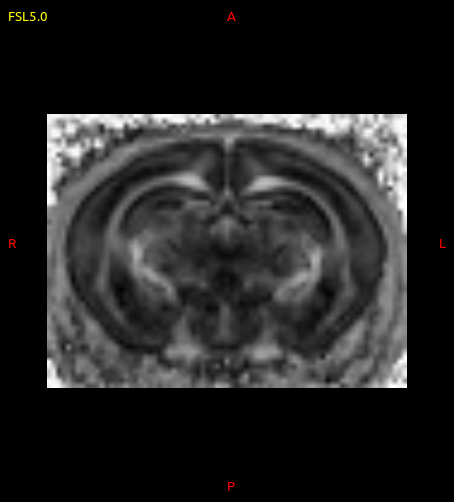

Lo que nos indicaría que entre más blanco esté el voxel, más restringida es la difusión y hay mayor FA, por el contrario si es más oscura, más libre es la difusión y el valor de FA decae.
**Implementación**

Se utilizaron DTI preprocesadas en el software MRtrix especializado para IRM, en este mismo se calculó el mapa de FA que fue nuestro objetivo a comparar. Para replicar a partir de DTI se utilizó el lenguaje Python como se muestra a continuación, se hace especial mención en el uso de la paquetería Nibabel que permite pasar de imágenes DTI en formato .nii a arreglos n-dimensionales con formato numpy:

In [1]:
##se cargan las librerías necesarias
import numpy as np 
import nibabel as nib##librería para cargar DTI
from numpy import linalg as LA##Se carga linalg para poder hacer el cálculo de eigenvectores y valores
from math import sqrt

Posteriormente se carga nuestra imágen DTI (N9_p28_tensor.nii) y se convierte a un arreglo de numpy, observamos que es un arreglo con 83 voxeles en el eje X, 56 voxeles en el eje Y, 40 voxeles en el eje Z, y nuestra 4 dimesión que como se menciona en la introducción es de tamaño 6.

In [2]:
img = nib.load("N9_p28_tensor.nii") 
img1 = img.get_fdata()
np.shape(img1)

(83, 56, 40, 6)

Se crea un arrego de las mismas dimesiones espaciales llamado fa, en donde se pondrá en valor de FA para cada voxel, en principio estará lleno de 0.

In [3]:
fa=np.zeros(np.shape(img1)[0:3])
np.shape(fa)

(83, 56, 40)

Definimos algunas funciones que servirán para los calculos necesarios:

tomatrix: esta función convierte nuestro arreglo de dimensión 6 en una matriz 3x3, esto con el fin de poder calcular sus eigenvectores con las funciones de numpy. Recibe de entrada el arreglo y devuelve la matriz

calcfa: función que calcula el fa, recibe de entrada los eigenvalores y  devuelve fa

In [21]:
def tomatrix(arr):
    mat=np.zeros((3,3))
    mat[0][0]=arr[0]
    mat[1][1]=arr[1]
    mat[2][2]=arr[2]
    mat[0][1]=mat[1][0]=arr[3]
    mat[0][2]=mat[2][0]=arr[4]
    mat[1][2]=mat[2][1]=arr[5]
    return mat

def calfa(a,b,c):
    if a==0 and b==0 and c==0:##Es necesaria esta parte para evitar divisiones entre 0
        return 0
    else:
        tra=(a+b+c)/3
        fa=sqrt(3*((a-tra)**2+(b-tra)**2+(c-tra)**2)/(2*(a**2+b**2+c**2)))
        return fa


Ahora, para cada voxel de nuestra imagen img1, se calculan los eigenvalores de su matriz D, y se calcula el FA usando las funciones declaradas, se llena el arreglo fa.

In [28]:
for i in range(0,fa.shape[0]):
    for j in range(0,fa.shape[1]):
        for k in range(0,fa.shape[2]): 
            x=img1[i][j][k]
            w, v = LA.eig(tomatrix(x))
            fa[i][j][k]=calfa(w[0],w[1],w[2])

Ya con nuestro mapa de FA generado ahora podemos comparar con el original, se carga el archivo("N9_p28_fa.nii") 

In [33]:
faorig= nib.load("N9_p28_fa.nii") 
faorig1= faorig.get_fdata()

Para la comparación se restarán los valores de ambos mapas para cada valor, se elevarán al cuadrado (para evitar signos) y se sumarán, el resultado debería ser cero o muy aproximando.

In [39]:
##se crea una variable en la que se guardará la suma
suma=0
for i in range(0,fa.shape[0]):
    for j in range(0,fa.shape[1]):
        for k in range(0,fa.shape[2]): 
            suma+=(fa[i][j][k]-faorig1[i][j][k])**2

Ahora se imprime el valor de nuestra suma:

In [41]:
suma

3.806353918522602e-12

Entonces tenemos que 3.806353918522602e-12$\approx$0, por lo que podemos decir que satisfactoriamente logramos calcular FA de manera "manual".

**Conclusiones**
La primera observación es que logramos calcular FA de forma correcta, y la pequeña variación que tenemos podría deberse a la forma en que se calculan los eigenvalores, intenté encontrar como lo hace el programa original pero no encontré documentación al respecto.
Pero, la mayor conclusión (además de lograr calcular FA de manera correcta), es que es importante conocer los conceptos y teoría detrás de lo que normalmente hacen los softwares de forma automática, ya que muchas veces no se entiende el trasfondo. Entonces, si por ejemplo, llegara a haber un error en el software, es posible corregirlo o implementarlo en algún otro lado para no topar con pared. Como se observó además, se usaron herramientas aprendidas en el curso de Álgebra Matricial que muchas veces se dan por sentadas pero los conceptos están presentes, en particular el tema de eigenvalores y eigenvectores.

**Referencias**

Alexander, A. L., Lee, J. E., Lazar, M., & Field, A. S. (2007). Diffusion tensor imaging of the brain. Neurotherapeutics, 4(3), 316-329.

**De último paper solo se uso la fórmula para calcular FA ya que en el anterior estaba incorrecta**
Kimura, M., Yabuuchi, H., Matsumoto, R., Kobayashi, K., Yamashita, Y., Nagatomo, K., ... & Yamasaki, Y. (2020). The reproducibility of measurements using a standardization phantom for the evaluation of fractional anisotropy (FA) derived from diffusion tensor imaging (DTI). Magnetic Resonance Materials in Physics, Biology and Medicine, 33(2), 293-298.